<a href="https://colab.research.google.com/github/kimtomato/ML_Study/blob/master/FL_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade tensorflow_federated_nightly
!pip install --quiet --upgrade nest_asyncio

import nest_asyncio
nest_asyncio.apply()

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)
tff.federated_computation(lambda:'Hello world!')()

b'Hello world!'

# 입력데이터 준비

## federation dataset은 비i.i.d 데이터 셋
MNIST-federation version
(non-iid)


In [ ]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [ ]:
len(emnist_train.client_ids)

3383

In [ ]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [ ]:
example_dataset= emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[77])
example_element = next(iter(example_dataset))
example_element['label'].numpy()


1

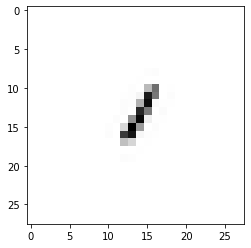

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
_ = plt.show()

## 하나의 클라이언트의 data sampling (77번)



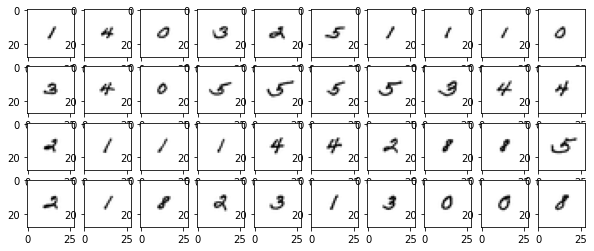

In [ ]:
figure = plt.figure(figsize=(10,4))
j=0
for example in example_dataset.take(40):
    plt.subplot(4,10,j+1)
    plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
    plt.axis('on')  # off로 변경가능
    j += 1

### fedaration 환경에서 client의 trainig_example 수는 client의 동작에 따라 큰 차이를 보일 수 있음  

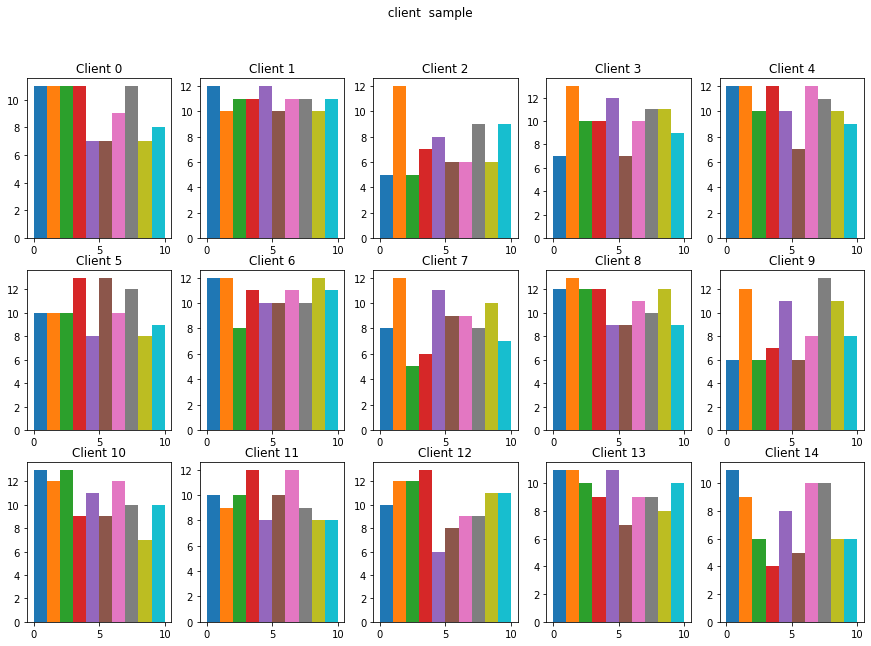

In [ ]:
# 각 client들의 example 수 
f = plt.figure(figsize=(15,10))
f.suptitle(' client  sample  ')
for i in range(15):
    client_dataset = emnist_train.create_tf_dataset_for_client(
        emnist_train.client_ids[i]
    )
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        label = example['label'].numpy()
        plot_data[label].append(label)
    plt.subplot(3,5,i+1)
    plt.title('Client {}'.format(i))
    for j in range(10):
        plt.hist(plot_data[j], density=False, bins=[0,1,2,3,4,5,6,7,8,9,10])  #히스토그램 그램 

### 각 client의 lable 이미지를 평균화하기 
하나의 레이블에 대한 사용자의 픽셀값의 평균 구하기 

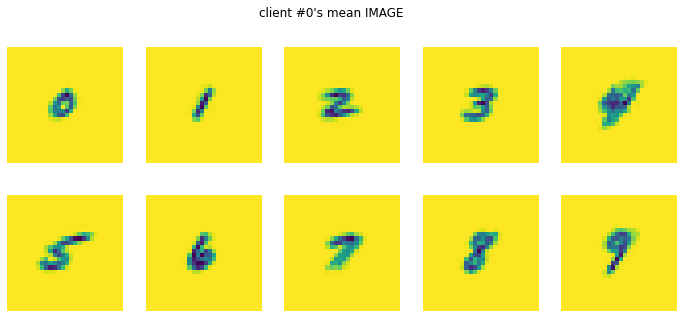

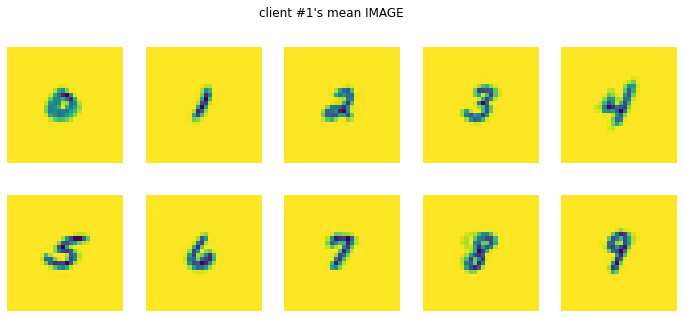

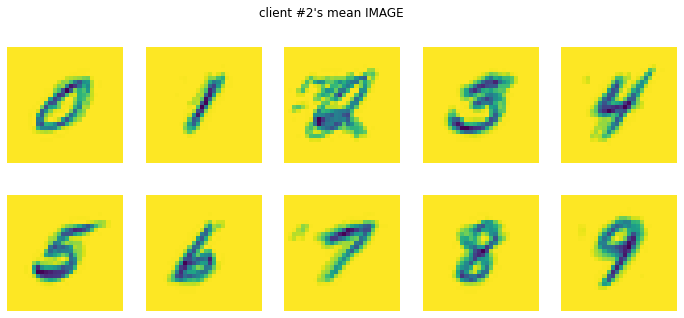

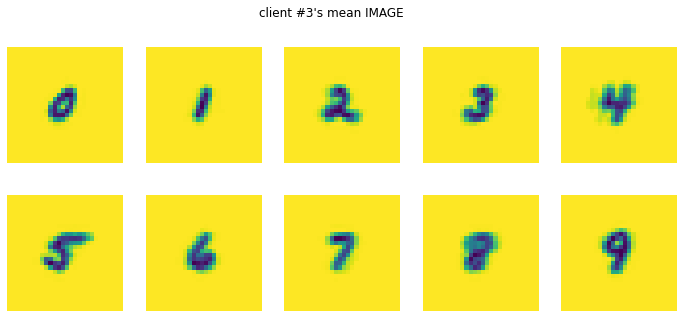

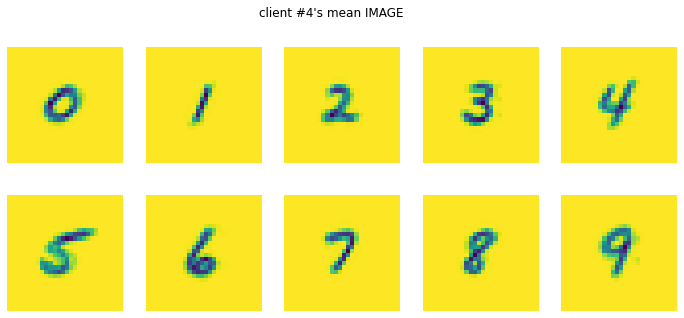

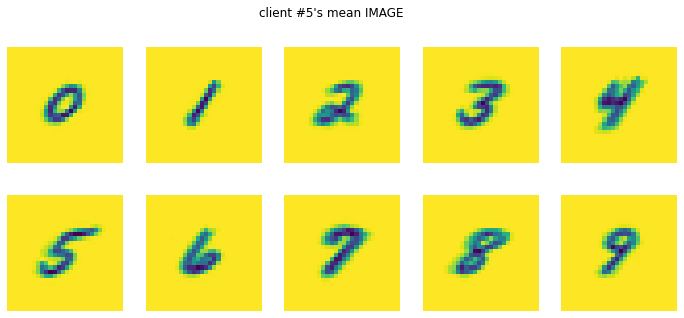

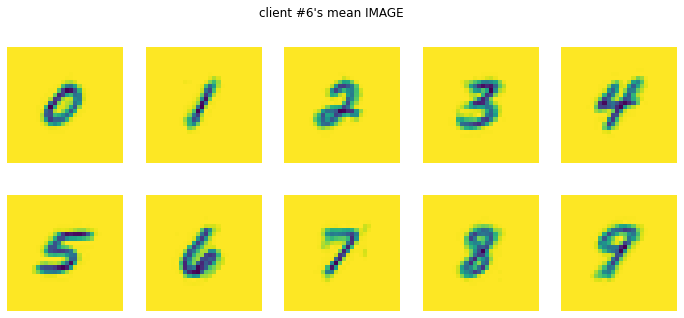

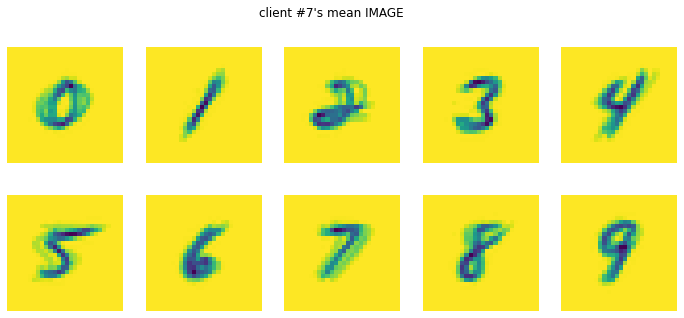

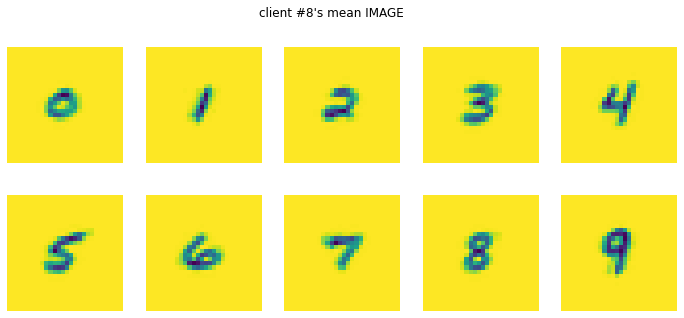

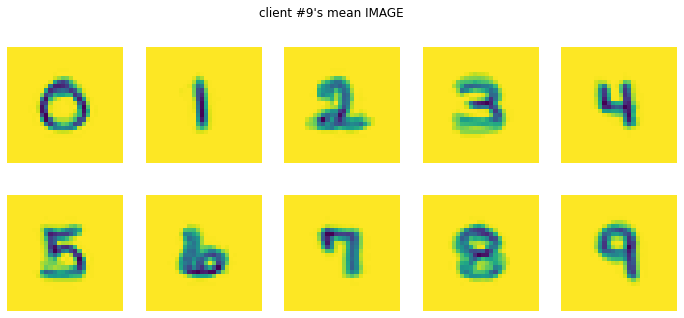

In [ ]:
for i in range(10):
    client_dataset = emnist_train.create_tf_dataset_for_client(
        emnist_train.client_ids[i]
    )
    plot_data= collections.defaultdict(list)
    for example in client_dataset:
        plot_data[example['label'].numpy()].append(example['pixels'].numpy())
        f = plt.figure(i,figsize=(12,5))
        f.suptitle("client #{}'s mean IMAGE".format(i))
    for j in range(10):
        mean_img = np.mean(plot_data[j],0)   #주어진 배열의 평균 
        plt.subplot(2,5,j+1)
        plt.imshow(mean_img.reshape((28,28)))
        plt.axis('off')

### 입력데이터 전처리 

In [ ]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER=10

def preprocess(dataset):

  def batch_format_fn(element):
    
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]), #픽셀값을 784개의 열로 평면화 
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [ ]:
preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(lambda x : x.numpy(), next(iter(preprocessed_example_dataset)))
sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[2],
                     [3],
                     [0],
                     [9],
                     [4],
                     [1],
                     [9],
                     [1],
                     [4],
                     [5],
                     [0],
                     [6],
                     [8],
                     [0],
                     [8],
                     [5],
                     [7],
                     [0],
                     [2],
                     [3]], dtype=int32))])

### 평가 라운드에 대한 입력으로 사용자의 dataset 목록 구성

In [ ]:
def make_federated_data(client_data, client_ids):
    return [
            preprocess(client_data.create_tf_dataset_for_client(x))
            for x in client_ids
    ]

### 학습에 참여할 Client 선택하기 
일반적으로 시뮬레이션시 라운드마다 참여할 클라이언트들의 집합이 다름
but 각 라운드에 무작위로 샘플링된 클라이언트 하위 집합이 있는 시스템에서 학습 내용을 수렵하는데에는 시간이 오래걸림 
따라서 해당 코드에서는 클라이언트 세트를 한 번 샘플링하고 수렴 속도를 높이기 위해 라운드에서 같은 클라이언트 세트를 재사용한다 

In [ ]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [ ]:
#keras로 모델 구성
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(784,)),
        tf.keras.layers.Dense(10, kernel_initializer='zeros'),
        tf.keras.layers.Softmax(),
    
    ])

def model_fn():
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


### federation data에 대해 모델 훈련 
client_optimizer : 각 클라이언트에서 로컬 모델 업데이트를 계산할 때 사용
server_optimizer: 평균 업데이트를 서버의 글로벌 모델에 적용 

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),   
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [ ]:
str(iterative_process.initialize.type_signature)  #서버의 상태는 model, optimizer_state로 구성
state = iterative_process.initialize()#initialize 서버 상태 구성

In [ ]:
"""next 서버 상태를 클라이언트에 알려줌, local data에 대한 훈련, 모델 업데이트 수집, 평균화로 
구성된 단일 라운드의 federate 평균화, 서버에서 업데이트된 새 모델을 생성"""
# next()는 서버에서 실행되는 함수가 아니라 전체 분산 계산의 선언적 함수형 표현!
# 일부 입력의 경우 서버에서 제공하지만 참여하는 각 기기는 자체 로컬 데이터를 제공 'ru

#ROUND1 훈련
state, metrics = iterative_process.next(state, federated_train_data)
print('round 1, metrics{}' .format(metrics))

round 1, metricsOrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.116460904), ('loss', 3.057401)])), ('stat', OrderedDict([('num_examples', 4860)]))])


In [ ]:
#ROUND 11
NUM_ROUNDS = 11
for round_num in range(2,NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.15164609), ('loss', 2.895167)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.15164609), ('loss', 2.8948193)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.16728395), ('loss', 2.7781904)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round  5, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.20781893), ('loss', 2.6038